In [26]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

import warnings
import numpy as np
from collections import OrderedDict

import os

from lob_data_utils import lob, db_result, gdf_pca, model, stocks_numbers
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
data_length = 24000
stocks = ['4851']
gdf_filename_pattern = 'gdf_{}_r{}_s{}_K50'
gdf_parameters = stocks_numbers.rs_params
print(gdf_parameters)
should_save_fig = True

[(0.1, 0.1), (0.1, 0.5), (0.01, 0.1), (0.01, 0.5)]


In [66]:
gdf_dfs = {}
for stock in stocks:
    gdf_dfs[stock] = []
    for r, s in gdf_parameters:
        gdf_dfs[stock].append(gdf_pca.SvmGdfResults(
            stock,  r=r, s=s, data_length=data_length, 
            gdf_filename_pattern=gdf_filename_pattern))

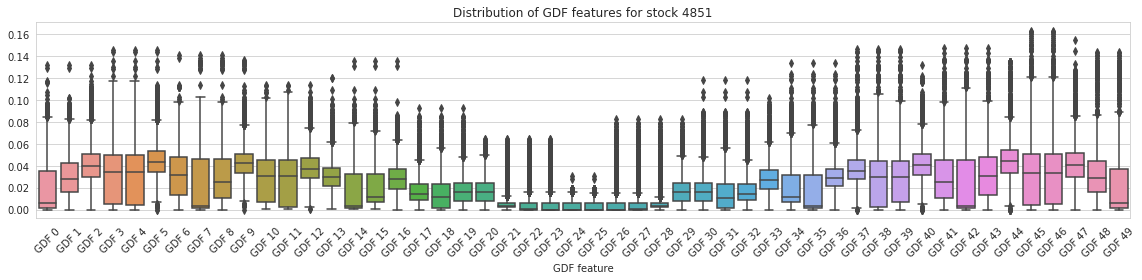

In [67]:
gdf_columns = ['gdf_' + str(i) for i in range(0, 50)]

fig, ax = plt.subplots(1, 1, figsize=(16, 4), sharex=True, sharey=True)

df_tmp = gdf_dfs[stocks[0]][0].df
sns.boxplot(data=df_tmp[gdf_columns], ax=ax)
ax.set_xticklabels([g.replace('_', ' ').upper() for g in gdf_columns], rotation=45)

ax.set_title('Distribution of GDF features for stock ' + str(stocks[0]))
ax.set_xlabel('GDF feature')
ax.set_ylabel('')
plt.tight_layout()

if should_save_fig:
    plt.savefig('gdf_feature_overview.png')

In [ ]:
## PCA

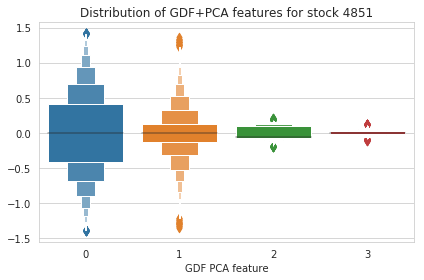

In [68]:
g = gdf_dfs[stocks[0]][0]
pca = g.get_pca('pca_n_gdf_que_prev')
sns.boxenplot(data=(pca.transform(g.df[g.feature_columns_dict['pca_n_gdf_que_prev']])))
plt.xlabel('GDF PCA feature')
plt.title('Distribution of GDF+PCA features for stock ' + str(stocks[0]))
plt.tight_layout()
if should_save_fig:
    plt.savefig('gdf_pca_feature_overview.png')